## **1.Subtask 1 - Polarization detection**


### **1.1 Imports**

In [20]:
#!unzip dev_phase.zip

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install iterative-stratification

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score,confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime

import pandas as pd
import numpy as np
import random
import os
import zipfile
from typing import Dict
import joblib
import seaborn as sns


In [24]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

In [58]:

def set_global_seed(seed: int = 42):
    """
    Set seed for reproducibility across Python, Numpy

    Args:
        seed (int): Seed value to use.
    """


    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)



    print(f"[INFO] Global seed set to {seed}")


In [26]:
set_global_seed(42)

[INFO] Global seed set to 42


#### **1.1.1 Helper Functions**

In [27]:

def plot_top_tfidf_words(tfidf_vectorizer, X, top_k=20, title="Top TF-IDF Words",naming='tf idf'):
    """
    Plot top-k words by mean TF-IDF score.
    """
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    mean_tfidf = X.mean(axis=0).A1

    top_idx = mean_tfidf.argsort()[-top_k:][::-1]

    plt.figure(figsize=(10,6))
    plt.barh(feature_names[top_idx][::-1], mean_tfidf[top_idx][::-1])
    plt.xlabel("Mean TF-IDF Score")
    plt.title(title)
    plt.tight_layout()

    plt.savefig(f'drive/MyDrive/NLP/top_words_org_{naming}.pdf',format='pdf',dpi=300)
    plt.show()

def plot_confusion_matrix_binary(y_true, y_pred, title,naming):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Not Polarized", "Polarized"]
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.savefig(f'drive/MyDrive/NLP/confusion_mat_org_{naming}.pdf',format='pdf',dpi=300)
    plt.show()

def plot_label_confusion_matrix(y_true, y_pred, label_names, title,naming):
    """
    Plot a label-label confusion matrix for multi-label classification.

    y_true: DataFrame (n_samples, n_labels)
    y_pred: ndarray (n_samples, n_labels)
    """
    n_labels = len(label_names)
    matrix = np.zeros((n_labels, n_labels), dtype=int)

    for i in range(n_labels):
        for j in range(n_labels):
            # Count samples where label i is true and label j is predicted
            matrix[i, j] = np.sum(
                (y_true.iloc[:, i] == 1) & (y_pred[:, j] == 1)
            )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matrix,
        xticklabels=label_names,
        yticklabels=label_names,
        annot=True,
        fmt="d",
        cmap="Blues"
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'drive/MyDrive/NLP/multi_confusion_mat_org_{naming}.pdf',format='pdf',dpi=300)
    plt.show()


### 1.2 Data Import

In [28]:
# Load the training and validation data for subtask 1

train_eng = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/eng.csv')
train_hau = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/hau.csv')


train_eng, val_eng = train_test_split(
    train_eng,
    test_size=0.1,
    shuffle=True,
    stratify=train_eng['polarization'],
    random_state=40
)

train_hau, val_hau = train_test_split(
    train_hau,
    test_size=0.1,
    shuffle=True,
    stratify=train_hau['polarization'],
    random_state=40
)



train_t1 = pd.concat([train_eng, train_hau], ignore_index=True)
val_t1 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t1=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/eng.csv')
dev_set_hau_t1=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/hau.csv')


train_t1.head()

,id,text,polarization
0,eng_54dde3b05be9510ecb5a32e59c3f5654,NATO has taken over coordination of Western mi...,0
1,eng_ca99e417ba56c186664ad50b13aee3bf,"TRUMP LIE 718 ""Not statistically possible. Rig...",1
2,eng_2e927c0378772abd03b9d9dfe77cdd3d,Russians didnt kill anyone in Ukraine invasion,0
3,eng_928a32380ac569d1dc82cb13c477e07f,Kamala Harris is the funniest person Kamala Ha...,0
4,eng_702a151aa2145b678a2379320dbd604b,"Mike Pence R, IN Norm Coleman R, MN",0


### **1.3 TF-IDF Vectorizer & DataSet**


In [29]:
tfidf=TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)
# TF-IDF
X_train_t1 = tfidf.fit_transform(train_t1['text'])
X_val_t1 = tfidf.transform(val_t1['text'])

# Labels
y_train_t1 = train_t1['polarization']
y_val_t1 = val_t1['polarization']


### **1.4 Model Training**

#### **1.4.1 Training Model**

In [30]:
def train_evaluate_logreg(X_train, y_train, X_val, y_val, multi_label=False):
    if multi_label:
        # Use one-vs-rest scheme for multi-label classification
        from sklearn.multiclass import OneVsRestClassifier
        clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    else:
        clf = LogisticRegression(max_iter=1000)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    # Metrics
    if multi_label:
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_micro = f1_score(y_val, y_pred, average='micro')
        return clf, {'f1_macro': f1_macro, 'f1_micro': f1_micro}
    else:
        accuracy = accuracy_score(y_val, y_pred)
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_micro = f1_score(y_val, y_pred, average='micro')
        return clf, {'accuracy': accuracy, 'f1_macro': f1_macro, 'f1_micro': f1_micro}


In [31]:
# Train Logistic Regression
clf_t1, metrics_t1 = train_evaluate_logreg(X_train_t1, y_train_t1, X_val_t1, y_val_t1)
print("Subtask 1 metrics:", metrics_t1)

Subtask 1 metrics: {'accuracy': 0.8156748911465893, 'f1_macro': 0.6526790427765672, 'f1_micro': 0.8156748911465893}


#### **1.4.2 Testing Dev Set**

In [32]:
X_dev_eng_t1 = tfidf.transform(dev_set_eng_t1['text'])
X_dev_hau_t1 = tfidf.transform(dev_set_hau_t1['text'])

# Predict
y_dev_eng_t1 = clf_t1.predict(X_dev_eng_t1)
y_dev_hau_t1 = clf_t1.predict(X_dev_hau_t1)

pred_data_t1 = {
    "eng": {'ids': dev_set_eng_t1['id'].tolist(), 'results': y_dev_eng_t1},
    "hau": {'ids': dev_set_hau_t1['id'].tolist(), 'results': y_dev_hau_t1}
}


#### **1.4.3 Making Submission Package**

In [33]:
# --- Helper: Save a single prediction CSV ---
def save_prediction_csv(df: pd.DataFrame, lang_code: str, folder: str):
    """Save a DataFrame as a csv."""
    file_path = os.path.join(folder, f"pred_{lang_code}.csv")
    df.to_csv(file_path, index=False)
    return file_path

# --- Helper: Zip a folder ---
def zip_folder(folder_path: str, zip_path: str):
    """Create a zip file of the folder."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

# --- Main function: Create submission zip ---
def create_submission_zip(task,predictions: Dict[str, pd.DataFrame], output_dir=".",):
    """
    function to create submission zip for Subtask.
    """
    zip_name=f"{task}.zip"
    # Folder for submission files
    submission_folder = os.path.join(output_dir, task)
    os.makedirs(submission_folder, exist_ok=True)

    # Save each prediction CSV
    for lang_code, df in predictions.items():
        save_prediction_csv(df, lang_code, submission_folder)

    # Create zip
    zip_path = os.path.join(output_dir, zip_name)
    zip_folder(submission_folder, zip_path)
    print(f"Submission zip created at: {zip_path}")


In [34]:
submission_dict = {}

for lang in pred_data_t1:
    df = pd.DataFrame({
        "id": pred_data_t1[lang]['ids'],
        "polarization": pred_data_t1[lang]['results']
    })
    submission_dict[lang] = df

create_submission_zip('subtask_1',submission_dict)

Submission zip created at: ./subtask_1.zip


#### **1.4.4 Saving the Model**

In [35]:
def save_model(model, path: str):
    """Save a sklearn model to disk."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    joblib.dump(model, path)
    print(f"Model saved at: {path}")

In [36]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='TF_IDF'
save_path = f"saved_model_t1_{naming}_f1_{metrics_t1['f1_macro']:.4f}_{timestamp}"
save_model(clf_t1, 'drive/MyDrive/NLP/models'+'//'+save_path)

Model saved at: drive/MyDrive/NLP/models//saved_model_t1_TF_IDF_f1_0.6527_20251216_165354


### **1.5 Plot of Important Words**

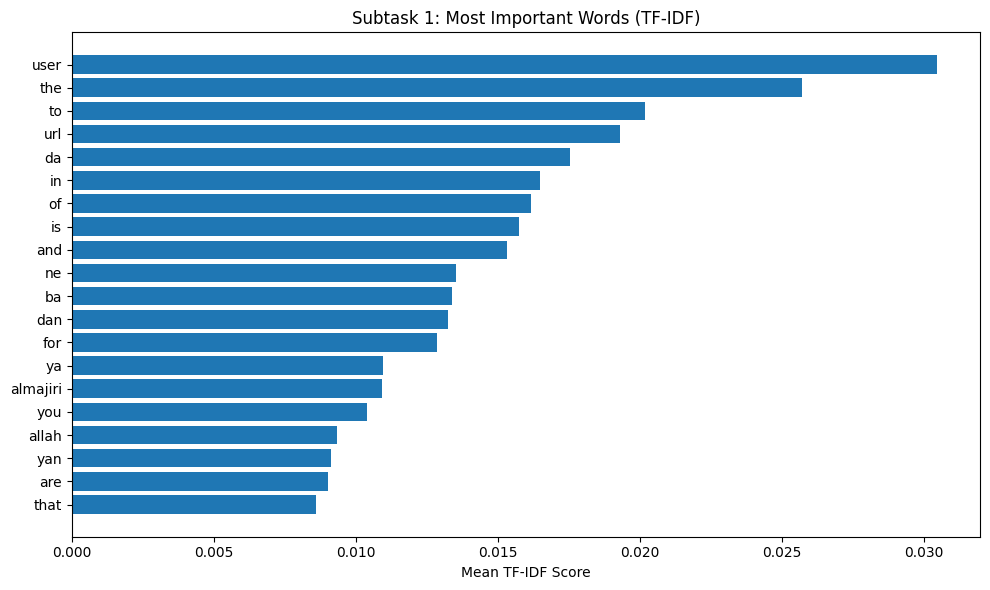

In [37]:
plot_top_tfidf_words(
    tfidf,
    X_train_t1,
    top_k=20,
    title="Subtask 1: Most Important Words (TF-IDF)",
    naming='TF IDF_T1_words'
)

### **1.6 Confusion Matrix**

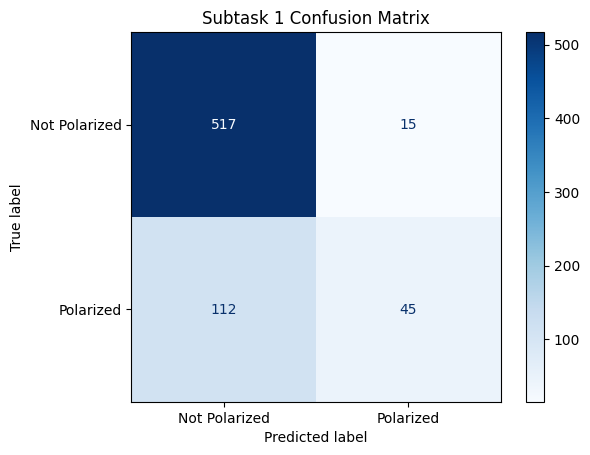

In [38]:
y_val_pred_t1 = clf_t1.predict(X_val_t1)

plot_confusion_matrix_binary(
    y_val_t1,
    y_val_pred_t1,
    title="Subtask 1 Confusion Matrix",
    naming='TF IDF_T1'
)

# **2.Subtask 2: Polarization Type Classification**

### **2.1 Data Import**

In [39]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def multilabel_split(df, labels, test_size=0.1, seed=40):
    splitter = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=seed
    )
    X = df.index.values
    y = df[labels].values

    for train_idx, val_idx in splitter.split(X, y):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

    return train_df, val_df

In [40]:

train_eng = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/eng.csv')
train_hau = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/hau.csv')

labels = ['gender/sexual','political','religious','racial/ethnic','other']
train_eng, val_eng = multilabel_split(train_eng, labels)
train_hau, val_hau = multilabel_split(train_hau, labels)

train_t2 = pd.concat([train_eng, train_hau], ignore_index=True)
val_t2 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/eng.csv')
dev_set_hau_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/hau.csv')

train_t2.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0


### **2.2 TF-IDF Vectorizer & DataSet**

In [41]:
tfidf=TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)

# TF-IDF
X_train_t2 = tfidf.fit_transform(train_t2['text'])
X_val_t2 = tfidf.transform(val_t2['text'])

# Labels
labels_t2 = ['gender/sexual','political','religious','racial/ethnic','other']
y_train_t2 = train_t2[labels_t2]
y_val_t2 = val_t2[labels_t2]

### **2.3 Model Training**

#### **2.4.1 Model Training**

In [42]:
clf_t2, metrics_t2 = train_evaluate_logreg(X_train_t2, y_train_t2, X_val_t2, y_val_t2, multi_label=True)
print("Subtask 2 metrics:", metrics_t2)


Subtask 2 metrics: {'f1_macro': 0.07597765363128492, 'f1_micro': 0.2585551330798479}


#### **2.4.2 Testing Dev Set**

In [43]:
X_dev_eng_t2 = tfidf.transform(dev_set_eng_t2['text'])
X_dev_hau_t2 = tfidf.transform(dev_set_hau_t2['text'])

y_dev_eng_t2 = clf_t2.predict(X_dev_eng_t2)
y_dev_hau_t2 = clf_t2.predict(X_dev_hau_t2)

labels_t2 = ['gender/sexual','political','religious','racial/ethnic','other']

pred_data_t2 = {
    "eng": {'ids': dev_set_eng_t2['id'].tolist(), 'results': y_dev_eng_t2},
    "hau": {'ids': dev_set_hau_t2['id'].tolist(), 'results': y_dev_hau_t2}
}

#### **2.3.3 Making Submission Package**

In [44]:
submission_dict = {}
for lang in pred_data_t2:
    df = pd.DataFrame({"id": pred_data_t2[lang]['ids'], **{lbl: pred_data_t2[lang]['results'][:,i] for i,lbl in enumerate(labels_t2)}})
    submission_dict[lang] = df


create_submission_zip('subtask_2',submission_dict)

Submission zip created at: ./subtask_2.zip


#### **2.3.4 Saving the Model**

In [45]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='TF_IDF'
save_path = f"saved_model_t2_{naming}_f1_{metrics_t2['f1_macro']:.4f}_{timestamp}"
save_model(clf_t1, 'drive/MyDrive/NLP/models'+'//'+save_path)

Model saved at: drive/MyDrive/NLP/models//saved_model_t2_TF_IDF_f1_0.0760_20251216_165406


### **2.5 Plot of Important Words**

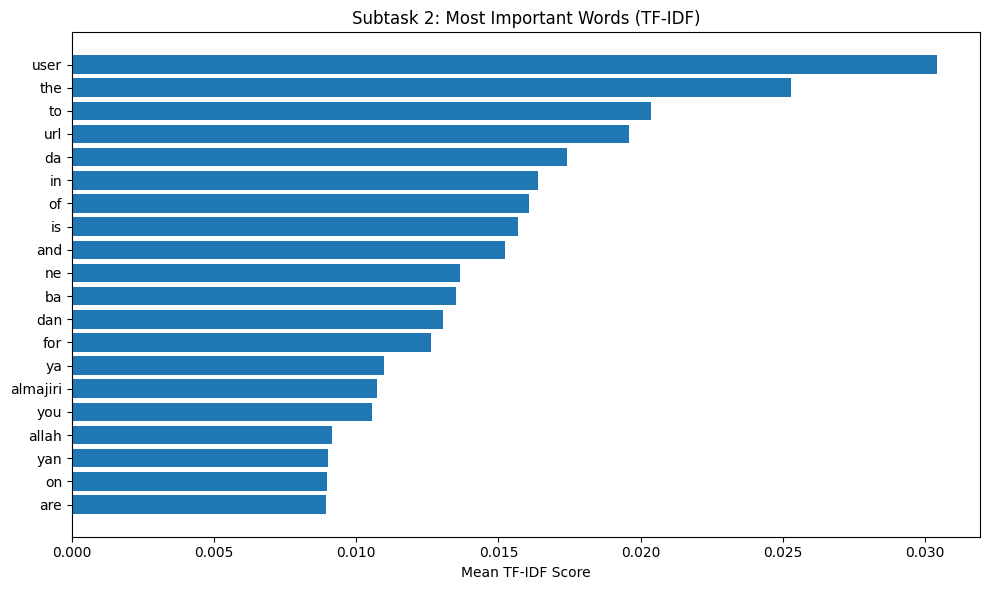

In [46]:
plot_top_tfidf_words(
    tfidf,
    X_train_t2,
    top_k=20,
    title="Subtask 2: Most Important Words (TF-IDF)",
    naming='TF IDF_T2_words'
)

### **2.6 Confusion Matrix**

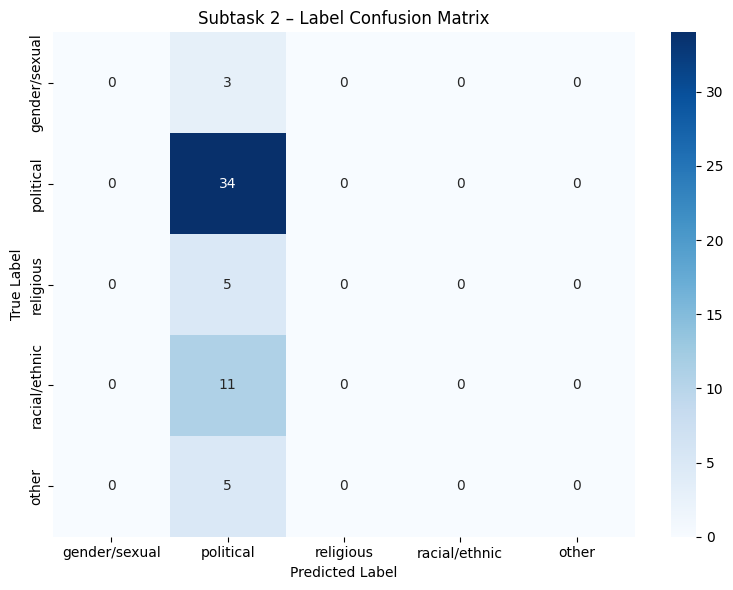

In [47]:
y_val_pred_t2 = clf_t2.predict(X_val_t2)

plot_label_confusion_matrix(
    y_val_t2,
    y_val_pred_t2,
    labels_t2,
    title="Subtask 2 – Label Confusion Matrix",
    naming='TF IDF_T2'
)

# 3.Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



### **3.1 Data Import**

In [49]:

train_eng = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/eng.csv')
train_hau = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/hau.csv')

labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']
train_eng, val_eng = multilabel_split(train_eng, labels)
train_hau, val_hau = multilabel_split(train_hau, labels)


train_t3 = pd.concat([train_eng, train_hau], ignore_index=True)
val_t3 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/eng.csv')
dev_set_hau_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/hau.csv')


train_t3.head()

,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,0


### **3.2 TF-IDF Vectorizer & DataSet**

In [50]:
tfidf=TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)

# TF-IDF
X_train_t3 = tfidf.fit_transform(train_t3['text'])
X_val_t3 = tfidf.transform(val_t3['text'])

# Labels
labels_t3 = ['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']
y_train_t3 = train_t3[labels_t3]
y_val_t3 = val_t3[labels_t3]

### **3.3 Model Training**

#### **3.3.1 Model Training**

In [51]:
# Train Logistic Regression with OneVsRest
clf_t3, metrics_t3 = train_evaluate_logreg(X_train_t3, y_train_t3, X_val_t3, y_val_t3, multi_label=True)
print("Subtask 3 metrics:", metrics_t3)

Subtask 3 metrics: {'f1_macro': 0.04672057929934135, 'f1_micro': 0.061611374407582936}


#### **3.3.2 Test on dev set**

In [52]:

X_dev_eng_t3 = tfidf.transform(dev_set_eng_t3['text'])
X_dev_hau_t3 = tfidf.transform(dev_set_hau_t3['text'])


y_dev_eng_t3 = clf_t3.predict(X_dev_eng_t3)
y_dev_hau_t3 = clf_t3.predict(X_dev_hau_t3)

labels_t3 = ['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']

pred_data_t3 = {
    "eng": {'ids': dev_set_eng_t3['id'].tolist(), 'results': y_dev_eng_t3},
    "hau": {'ids': dev_set_hau_t3['id'].tolist(), 'results': y_dev_hau_t3}
}

#### **3.3.3 Making Submission Package**

In [53]:
submission_dict = {}
for lang in pred_data_t3:
    df = pd.DataFrame({"id": pred_data_t3[lang]['ids'], **{lbl: pred_data_t3[lang]['results'][:,i] for i,lbl in enumerate(labels_t3)}})
    submission_dict[lang] = df

create_submission_zip('subtask_3',submission_dict)

Submission zip created at: ./subtask_3.zip


#### **3.3.4 Saving the Model**

In [54]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='TF_IDF'
save_path = f"saved_model_t3_{naming}_f1_{metrics_t2['f1_macro']:.4f}_{timestamp}"
save_model(clf_t1, 'drive/MyDrive/NLP/models'+'//'+save_path)

Model saved at: drive/MyDrive/NLP/models//saved_model_t3_TF_IDF_f1_0.0760_20251216_165831


### **3.5 Plot of Important Words**

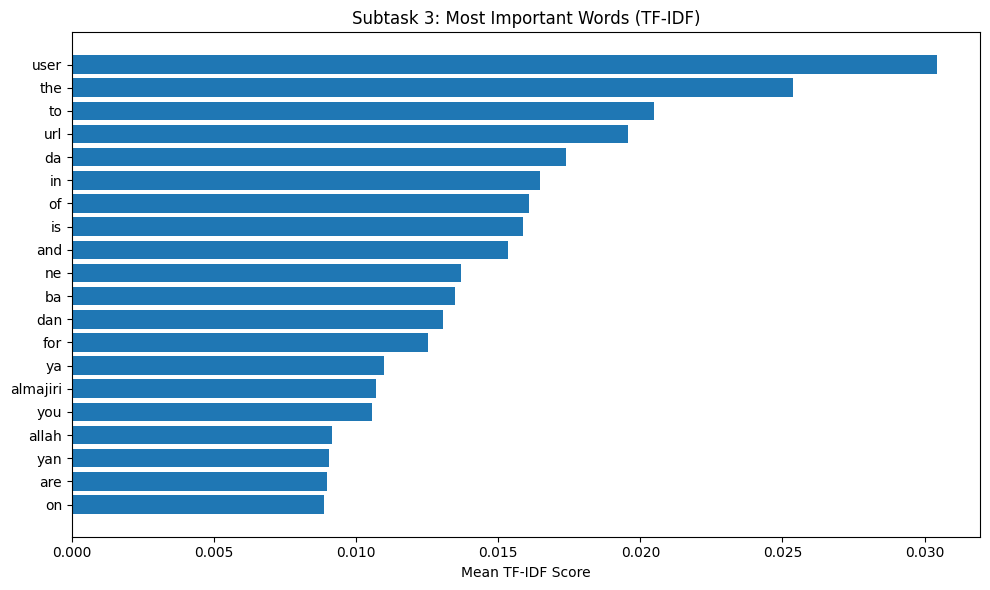

In [55]:
plot_top_tfidf_words(
    tfidf,
    X_train_t3,
    top_k=20,
    title="Subtask 3: Most Important Words (TF-IDF)",
    naming='TF IDF_T3_words'
)

### **3.6 Confusion Matrix**

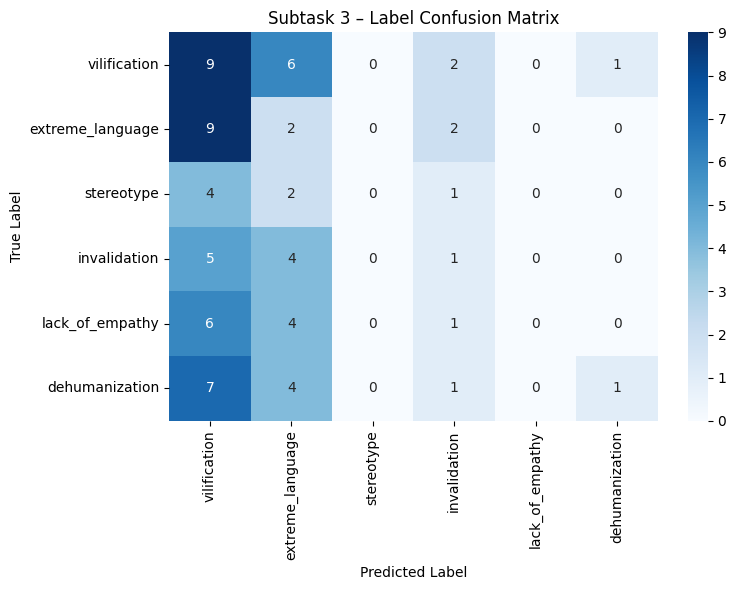

In [56]:
y_val_pred_t3 = clf_t3.predict(X_val_t3)

plot_label_confusion_matrix(
    y_val_t3,
    y_val_pred_t3,
    labels_t3,
    title="Subtask 3 – Label Confusion Matrix",
    naming='TF IDF_T3'
)